In [1]:
import jax
jax.config.update('jax_platform_name', 'cpu')
import numpyro
numpyro.set_host_device_count(8)

import sys
sys.path.append("..") 

import pandas as pd
import numpy as np
import pymc as pm
import pytensor
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import arviz as az
import geopandas as gpd

from laos_gggi import load_all_data, load_gpcc_data, load_emdat_data, load_shapefile, load_wb_data
from laos_gggi.replication_data import create_replication_data
from laos_gggi.const_vars import COUNTRIES_ISO, ISO_DICTIONARY
from laos_gggi.plotting import configure_plot_style, plot_ppc_loopit


configure_plot_style()
SEED = sum(list(map(ord, 'climate_bayes')))
rng = np.random.default_rng(SEED)

In [50]:
df = create_replication_data()
emdat = load_emdat_data()
wb = load_wb_data()
#Load shapefiles
world = load_shapefile('world', repair_ISO_codes=True)
laos = load_shapefile('laos')

In [53]:
damage_df = gpd.GeoDataFrame((emdat['df_raw_filtered_adj'][['ISO', 'End Year', 'Latitude', 'Longitude', 'River Basin', 'Total_Damage']]
                      .dropna(how='all', subset=['Latitude', 'Longitude'])
                      .assign(geometry = lambda x: gpd.points_from_xy(x.Longitude, x.Latitude),
                              year = lambda x: pd.to_datetime(x['End Year'], format='%Y'))
                     .drop(columns=['End Year'])
                     .replace({0.0: np.nan})),
                             crs=world.crs)

emdat_iso = damage_df.ISO.unique()
world_iso = world.ISO_A3.unique()
wb_iso = wb.index.get_level_values(0).unique()

# Codes in shapefile but not in EMDAT
common_codes = set(world_iso).intersection(set(emdat_iso)).intersection(set(wb_iso))
damage_df = damage_df.query('ISO in @common_codes').copy()
world = world.query('ISO_A3 in @common_codes').copy()
wb = (wb.reset_index().query('country_code in @common_codes').assign(year = lambda x: pd.to_datetime(x.year, format='%Y')).copy())

damage_df = (pd.merge(damage_df, wb, left_on=['ISO', 'year'], right_on=['country_code', 'year'], how='left')
             .dropna(subset=['population_density', 'gdp_per_cap', 'Population']))


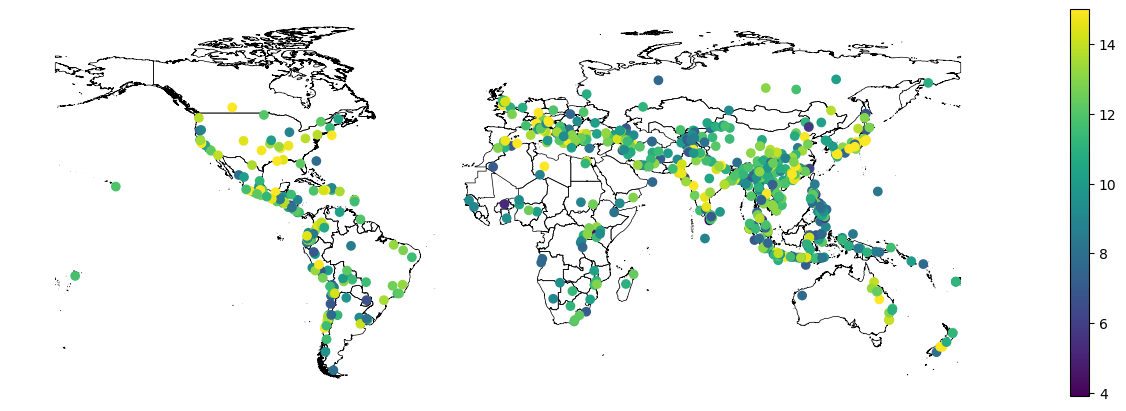

In [54]:
fig, ax = plt.subplots()
world.plot(ax=ax, facecolor='None', linewidth=0.5)
damage_df.assign(log_damage = lambda x: np.log(x.Total_Damage)).plot('log_damage', vmax=15, ax=ax, legend=True)
ax.axis('off')
plt.show()

In [6]:
from pyprojroot import here
water = gpd.read_file(here('data/shapefiles/HydroRIVERS_v10_shp/HydroRIVERS_v10.shp'))

In [28]:
big_rivers = water.query('ORD_CLAS == 1 and ORD_FLOW < 5')

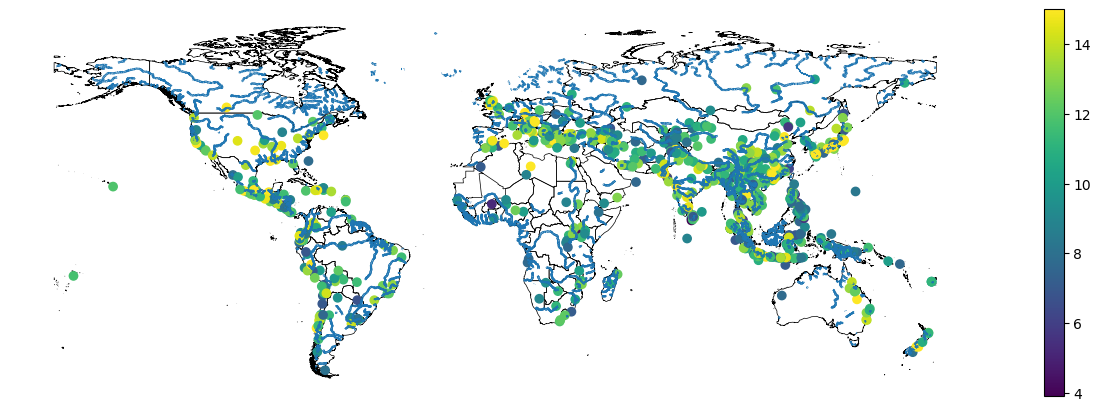

In [30]:
fig, ax = plt.subplots()
world.plot(ax=ax, facecolor='None', linewidth=0.5)
damage_df.assign(log_damage = lambda x: np.log(x.Total_Damage)).plot('log_damage', vmax=15, ax=ax, legend=True)
big_rivers.plot(ax=ax)
ax.axis('off')
plt.show()


In [82]:
from tqdm.notebook import tqdm
def get_distance_to_rivers(rivers, points):
    ret = pd.Series(np.nan, index=points.index, name='closest_river')
    rivers_km = rivers.copy().to_crs('EPSG:3395')
    points_km = points.copy().to_crs('EPSG:3395')
    for idx, row in tqdm(points_km.iterrows(), total=points.shape[0]):
        ret.loc[idx] = rivers_km.distance(row.geometry).min()
    return ret

In [83]:
closest_river = get_distance_to_rivers(big_rivers, damage_df)

  0%|          | 0/1577 [00:00<?, ?it/s]

In [93]:
damage_df = damage_df.join(river_distance / 1000) # meters to km
damage_df.assign(log_damage = lambda x: np.log(x.Total_Damage)).describe()

,Latitude,Longitude,Total_Damage,year,population_density,gdp_per_cap,Population,closest_river,log_damage
count,1577.000000,1577.000000,7.230000e+02,1577,1577.000000,1577.000000,1.577000e+03,1577.000000,723.000000
mean,15.254941,43.212658,1.543930e+06,2006-01-29 19:22:24.578313216,138.620968,7034.225057,2.657515e+08,173.795079,11.181486
min,-72.640000,-172.095000,5.000000e+01,1971-01-01 00:00:00,2.115134,274.131908,5.536600e+04,0.066938,3.912023
25%,0.382000,3.634000,1.000000e+04,2003-01-01 00:00:00,38.551519,1409.970821,2.012812e+07,39.434949,9.210340
50%,16.820000,59.472000,8.000000e+04,2008-01-01 00:00:00,96.440665,3242.239152,6.346142e+07,84.651042,11.289782
75%,33.193000,103.873000,4.590000e+05,2013-01-01 00:00:00,150.439754,6591.662494,2.068596e+08,206.415572,13.036803
max,62.340000,178.080000,2.100000e+08,2021-01-01 00:00:00,1257.462995,78893.807736,1.412360e+09,8368.762201,19.162618
std,21.099752,75.331522,9.849753e+06,NaN,152.835619,11065.396589,4.445645e+08,435.963323,2.594374


In [94]:
import xarray as xr

country_idx, countries = pd.factorize(damage_df.ISO)
year_idx, years = pd.factorize(damage_df.year)

X = damage_df[['River Basin', 'Population', 'gdp_per_cap', 'closest_river']].assign(has_river = lambda x: x['River Basin'].notna().astype(int)).drop(columns=['River Basin'])
X_gp = damage_df[['Latitude', 'Longitude']].copy()
# X_gp['year'] = X_gp['year'].dt.year

coords = {
    'country':countries,
    'year':years,
    'obs_idx':damage_df.index,
    'feature':X.columns,
    'gp_feature': X_gp.columns
}    

xr_idx = xr.Coordinates.from_pandas_multiindex(damage_df.rename(columns={'ISO':'country'}).set_index(['country', 'year']).index, 'obs_idx')

In [95]:
def centered(name, group_dim, mu_loc=0, mu_scale=1, sigma_alpha=2, sigma_beta=1, extra_dims=None, include_loc = True):
    if isinstance(group_dim, str):
        group_dim = (group_dim, )
    if isinstance(extra_dims, str):
        extra_dims = (extra_dims, )

    dims = group_dim if extra_dims is None else (*extra_dims, *group_dim)
    
    if include_loc:
        mu = pm.Normal(f'{name}_mu', mu=mu_loc, sigma=mu_scale, dims=extra_dims)
    else:
        mu = 0
        
    sigma = pm.Gamma(f'{name}_sigma', alpha=sigma_alpha, beta=sigma_beta, dims=extra_dims)
    offset = pm.Normal(f'{name}_offset', dims=dims)
    effect = pm.Deterministic(f'{name}_effect', mu + sigma * offset, dims=dims)
    return effect

In [170]:
pm.find_constrained_prior(
            pm.Gamma,
            lower=3,
            upper=10,
            mass=0.95,
            init_guess={"alpha": 10, "beta": 5},
            mass_below_lower=0,
        ),

({'alpha': 11.62233747026731, 'beta': 1.8612866994444914},)

In [165]:
from sklearn.preprocessing import StandardScaler
from pymc.model.transform.optimization import freeze_dims_and_data

scaler = StandardScaler()
X_scaled = X.copy()
X_scaled.loc[:, ['Population', 'gdp_per_cap', 'closest_river']] = scaler.fit_transform(X[['Population', 'gdp_per_cap', 'closest_river']].values)

In [166]:
m1, m2 = 50, 50
c = 1.5

In [223]:
with pm.Model(coords=coords) as model:
    country_idx_pt = pm.Data('country_idx', country_idx, dims=['obs_idx'])
    year_idx_pt = pm.Data('year_idx', year_idx, dims=['obs_idx'])
    X_pt = pm.Data('X', X_scaled.values, dims=['obs_idx', 'feature'])
    X_gp_pt = pm.Data('X_gp', X_gp, dims=['obs_idx', 'gp_features'])
    
    country_effect = centered('country', 'country', mu_scale=0.1, sigma_beta=10)
    year_effect = centered('year', 'year', include_loc=False, mu_scale=0.1, sigma_beta=10)
    
    beta = pm.Normal('beta', sigma=0.1, dims=['feature'])
        
    ell = pm.InverseGamma("ell", mu=6.0, sigma=6.5, dims="gp_feature")
    eta = pm.Gamma("eta", alpha=11, beta=2)
    cov_func = eta**2 * pm.gp.cov.ExpQuad(input_dim=2, ls=ell)
    
    gp = pm.gp.HSGP(m=[m1, m2], c=c, cov_func = cov_func)
    phi, sqrt_psd = gp.prior_linearized(X=X_gp_pt)

    basis_coeffs = pm.Normal("basis_coeffs", sigma=0.1, size=gp.n_basis_vectors)
    gp_effect = pm.Deterministic("gp_effect", phi @ (basis_coeffs * sqrt_psd), dims=['obs_idx'])    
    regression_effect = pm.Deterministic('regression_effect', X_pt @ beta, dims=['obs_idx'])
    
    mu = pm.Deterministic('mu', gp_effect + country_effect[country_idx_pt] + year_effect[year_idx_pt] + regression_effect, dims=['obs_idx'])
    sigma = pm.Exponential('sigma', lam=1)
    
    damage_hat = pm.LogNormal('damage_hat', mu=mu, sigma=sigma, dims='obs_idx',
                             observed=damage_df['Total_Damage'].values,
                             shape=country_idx_pt.shape[0])

with freeze_dims_and_data(model):
    prior = pm.sample_prior_predictive(compile_kwargs = {'mode':'JAX'})
prior = prior.assign_coords(xr_idx)

/home/jesse/mambaforge/envs/laos-climate-change/lib/python3.11/site-packages/pymc/model/core.py:1366: ImputationWarning: Data in damage_hat contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/home/jesse/mambaforge/envs/laos-climate-change/lib/python3.11/site-packages/pytensor/link/jax/linker.py:28: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x7F182092BBC0>), RNG(<Generator(PCG64) at 0x7F182092B920>), RNG(<Generator(PCG64) at 0x7F182092B760>), RNG(<Generator(PCG64) at 0x7F182092B680>), RNG(<Generator(PCG64) at 0x7F182092B5A0>), RNG(<Generator(PCG64) at 0x7F182092B4C0>), RNG(<Generator(PCG64) at 0x7F182092B840>), RNG(<Generator(PCG64) at 0x7F182092BCA0>), RNG(<Generator(PCG64) at 0x7F18209284A0>), RNG(<Generator(PCG64) at 0x7F182092BAE0>), RNG(<Generator(PCG64) at 0x7F182092BA00>), RNG(<Generator(PCG64) at 0x7F182092B3E0>)] will not be used in the compiled JAX graph. Inste

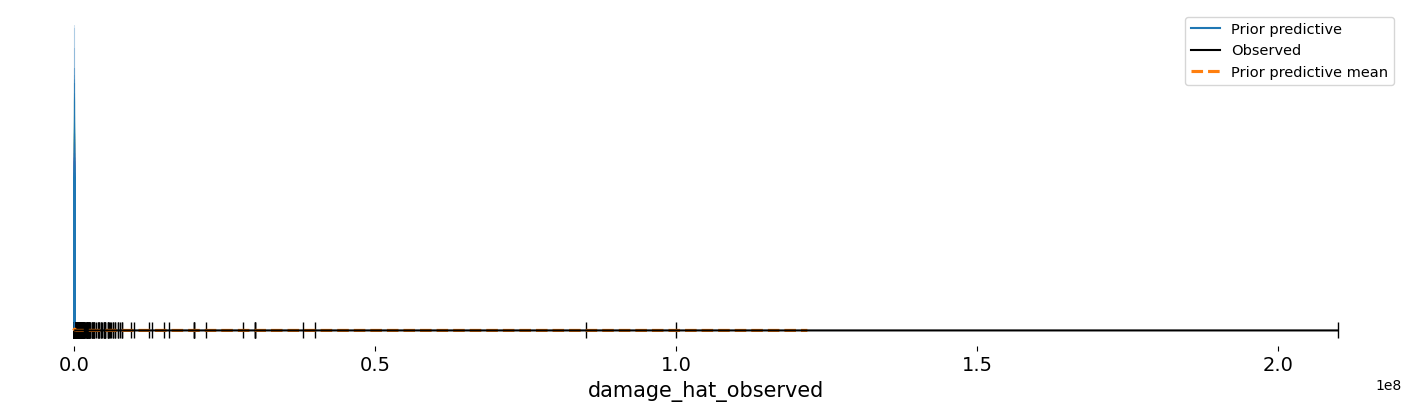

In [225]:
az.plot_ppc(prior, group='prior', observed=True, kind='kde', observed_rug=True);

In [ ]:
with freeze_dims_and_data(model):
    idata = pm.sample(nuts_sampler='numpyro', idata_kwargs={'log_likelihood':True}, chains=8, draws=500)
    idata = pm.sample_posterior_predictive(idata, extend_inferencedata=True, compile_kwargs={'mode':'JAX'})

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

<Axes: >

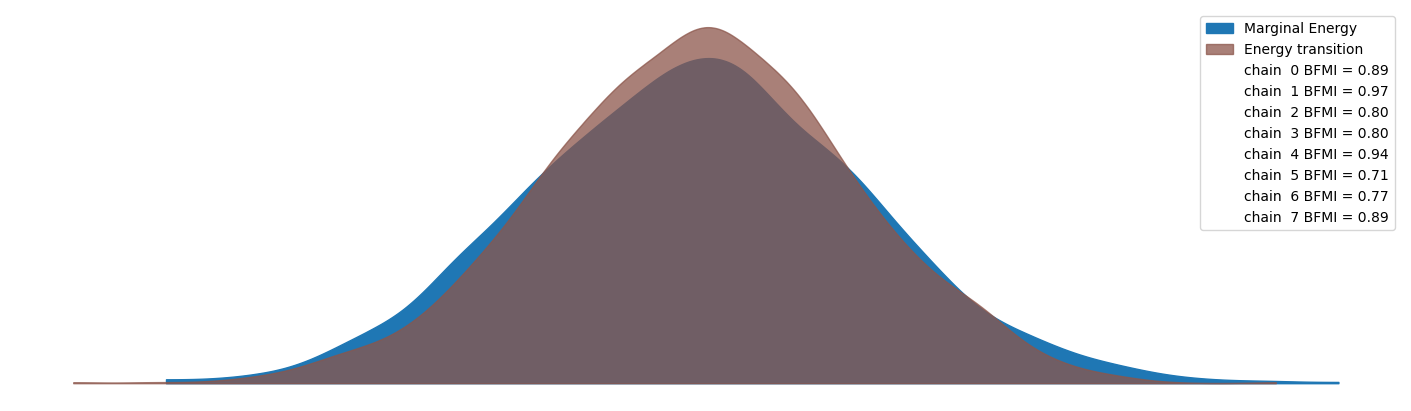

In [104]:
az.plot_energy(idata)

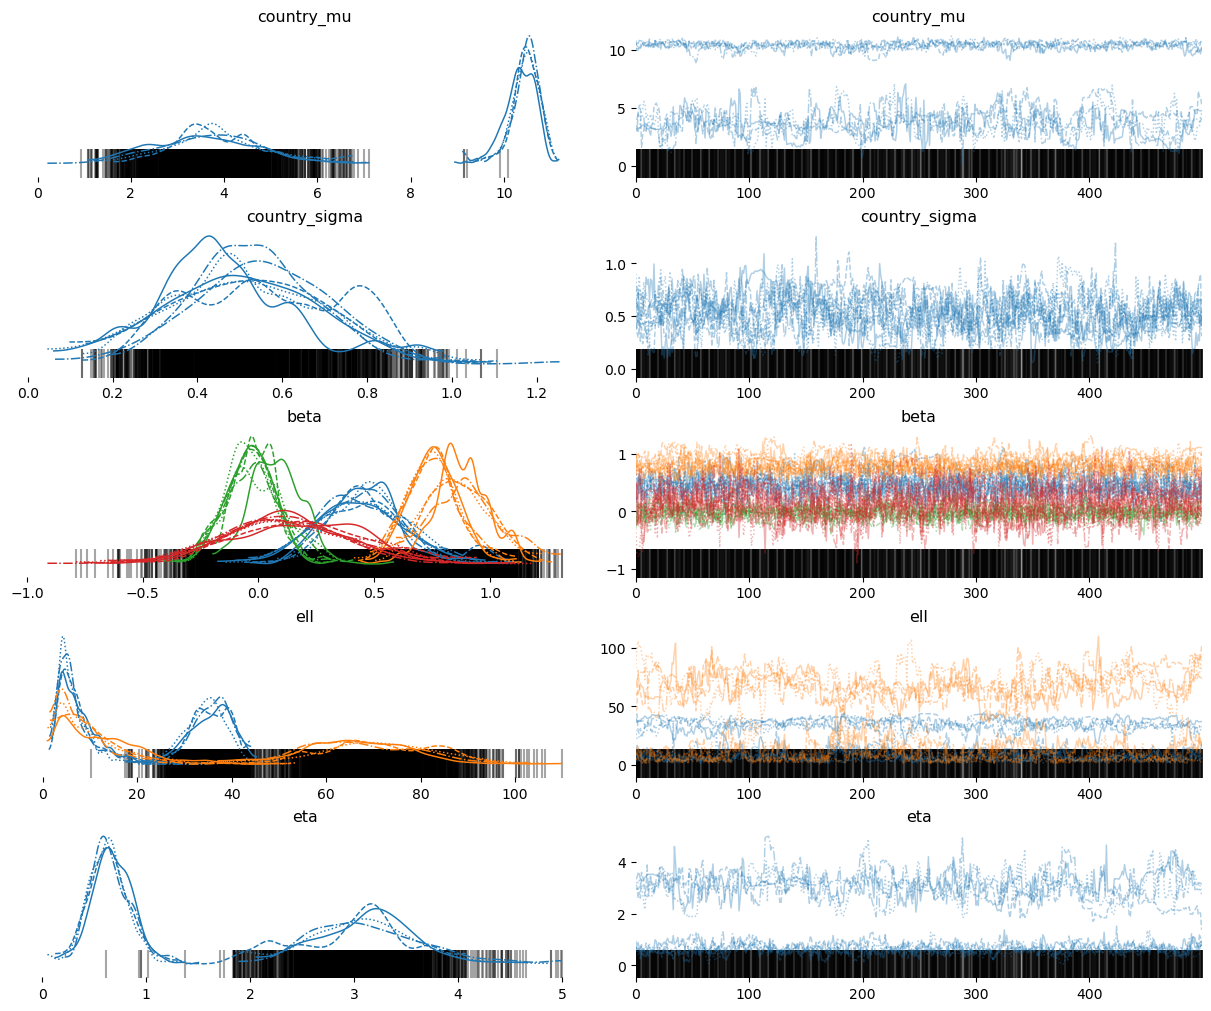

In [105]:
az.plot_trace(idata, var_names=['country_mu', 'country_sigma', 'beta', 'ell', 'eta']);

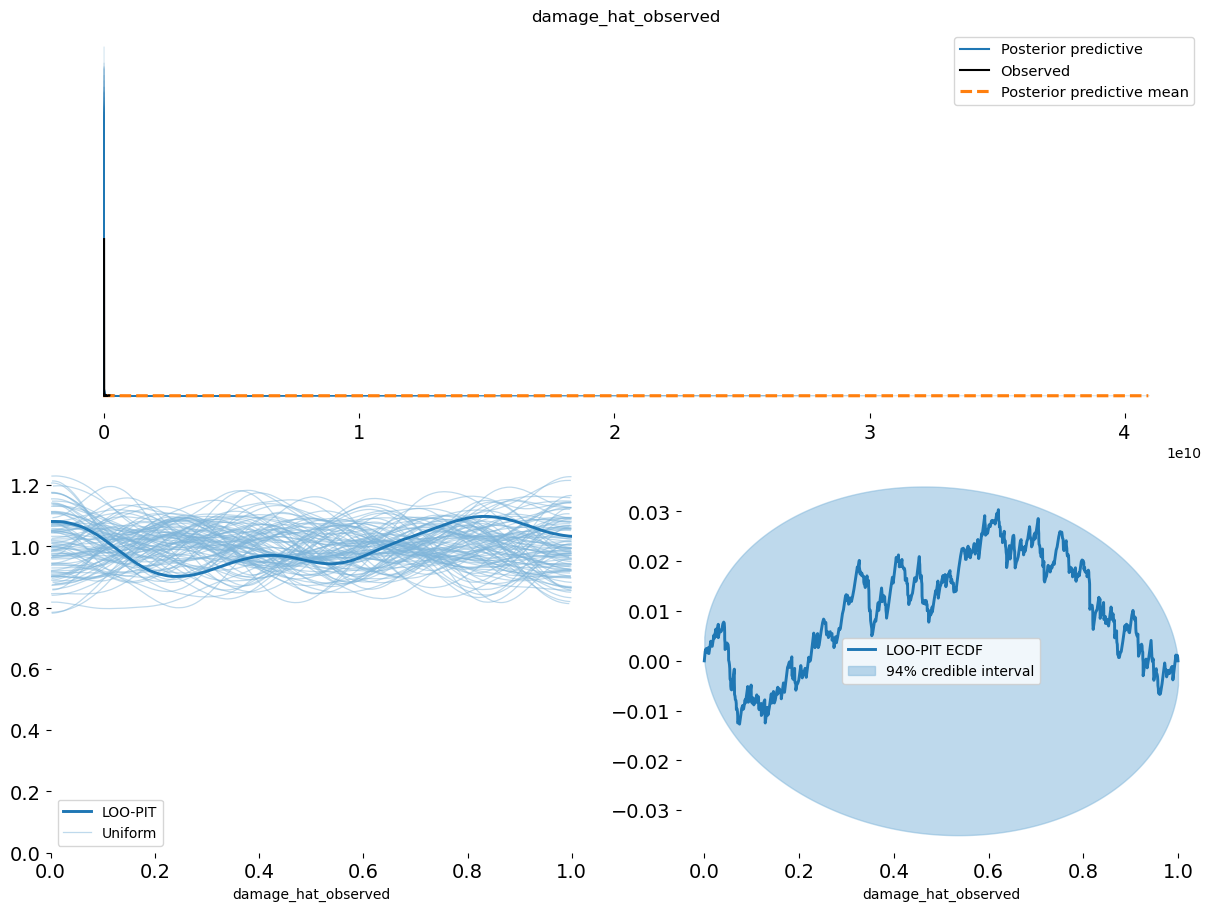

In [106]:
plot_ppc_loopit(idata, 'damage_hat_observed', kind='kde');

/tmp/ipykernel_1256136/2300488075.py:2: UserWarning: The figure layout has changed to tight
  plt.gcf().tight_layout()


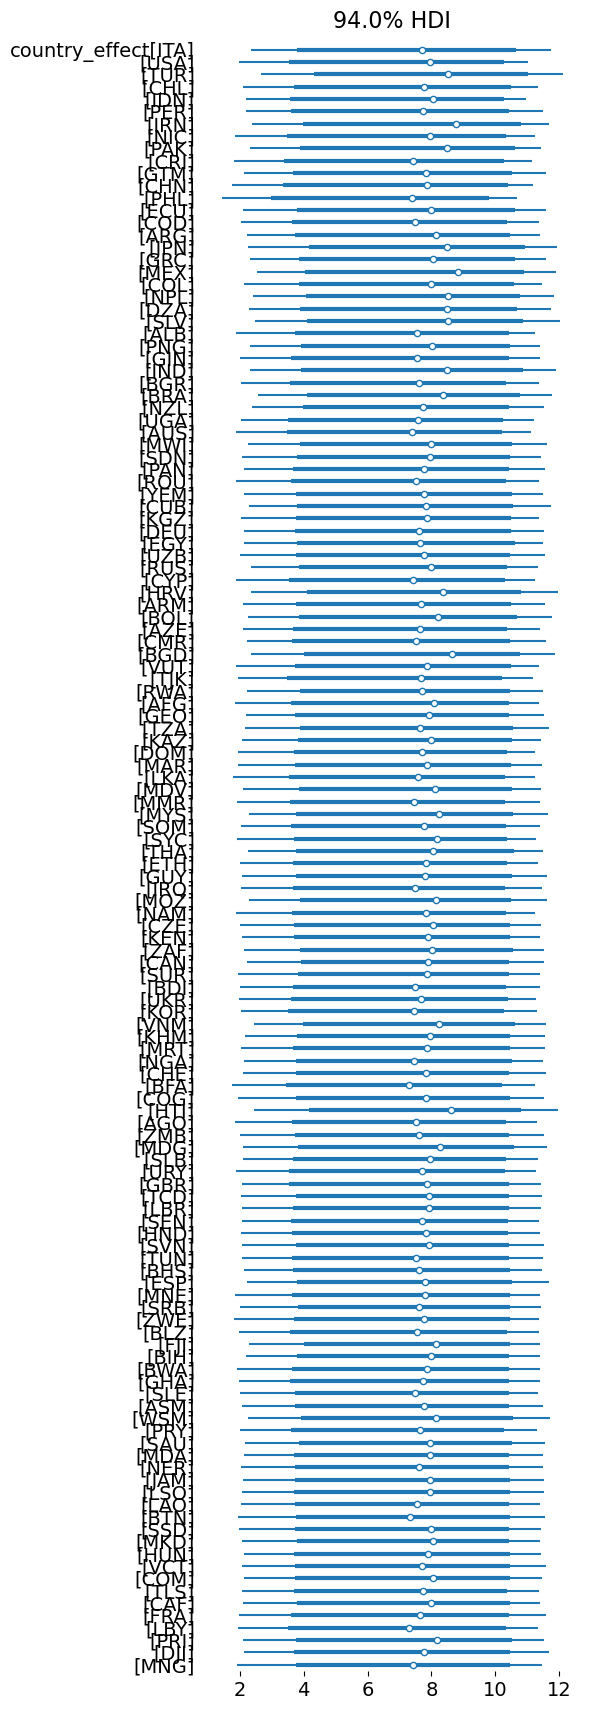

In [107]:
az.plot_forest(idata, var_names=['country_effect'], combined=True);
plt.gcf().tight_layout()
plt.show()

In [108]:
lon_min, lat_min, lon_max, lat_max = laos.bounds.values.ravel()
lon_grid = np.linspace(lon_min, lon_max, 100)
lat_grid = np.linspace(lat_min, lat_max, 100)

laos_grid = np.column_stack([x.ravel() for x in np.meshgrid(lon_grid, lat_grid)])
grid = gpd.GeoSeries(gpd.points_from_xy(*laos_grid.T), crs='EPSG:4326')
grid = gpd.GeoDataFrame({'geometry': grid})

In [119]:
laos_points = grid.overlay(laos, how='intersection').geometry
laos_points = laos_points.to_frame().assign(lon = lambda x: x.geometry.x, lat = lambda x: x.geometry.y)

In [120]:
laos_points

,geometry,lon,lat
0,POINT (105.88058 13.99669),105.880578,13.996687
1,POINT (105.95686 13.99669),105.956860,13.996687
2,POINT (106.03314 13.99669),106.033142,13.996687
3,POINT (106.10942 13.99669),106.109425,13.996687
4,POINT (105.8043 14.08355),105.804296,14.083549
...,...,...,...
2975,POINT (101.68506 22.42234),101.685057,22.422344
2976,POINT (101.76134 22.42234),101.761340,22.422344
2977,POINT (101.9139 22.42234),101.913904,22.422344
2978,POINT (101.99019 22.42234),101.990186,22.422344


In [121]:
point_river_distance = get_distance_to_rivers(big_rivers, laos_points)

  0%|          | 0/2980 [00:00<?, ?it/s]

<Axes: >

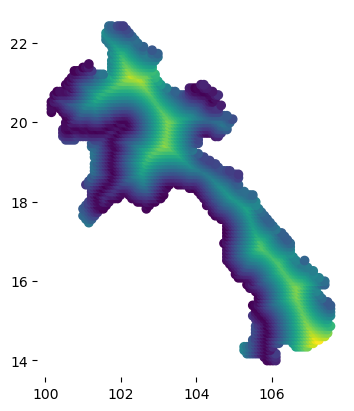

In [164]:
laos_points.join(point_river_distance).plot('closest_river')

In [127]:
scaler.fit_transform(X[].values)

StandardScaler()

In [158]:
with pm.Model(coords=coords) as plotting_model:
    laos_idx = countries.tolist().index('LAO')
    plot_year_idx = [x.year for x in years].index(2020)
    
    lao_row = 1097
    X_gp_laos = laos_points.values[:, 1:].astype(float)
    
#     laos_feature_data = pt.as_tensor_variable(scaler.transform(X.values)[lao_row, :])
    laos_feature_data = X.loc[[lao_row], ['Population', 'gdp_per_cap', 'closest_river']].values
    X_laos = np.ones((laos_points.shape[0], 1)) * laos_feature_data
    X_laos[:, -1] = point_river_distance.values
    X_laos = scaler.transform(X_laos)
    X_laos = np.column_stack((X_laos, np.zeros(X_laos.shape[0])))
    
    country_effect = pm.Flat('country_effect', dims=['country'])
    year_effect = pm.Flat('year_effect', dims=['year'])
    beta = pm.Flat('beta', dims=['feature'])
        
    ell = pm.Flat("ell", dims="gp_feature")
    eta = pm.Flat("eta")
    cov_func = eta**2 * pm.gp.cov.Matern32(input_dim=2, ls=ell)
    
    gp = pm.gp.HSGP(m=[m1, m2], c=1.5, cov_func = cov_func)
    phi, sqrt_psd = gp.prior_linearized(X=X_gp_laos)

    basis_coeffs = pm.Flat("basis_coeffs", size=gp.n_basis_vectors)
    gp_effect = phi @ (basis_coeffs * sqrt_psd)  
    
    mu_laos = pm.Deterministic('mu_laos', gp_effect + country_effect[laos_idx] + year_effect[plot_year_idx] + X_laos @ beta)
    sigma = pm.Flat('sigma')
    
    laos_damage = pm.LogNormal('laos_damage', mu=mu_laos, sigma=sigma)

with freeze_dims_and_data(plotting_model):
    idata_plot = pm.sample_posterior_predictive(idata, var_names=['laos_damage'], compile_kwargs={'mode':'JAX'})

/home/jesse/mambaforge/envs/laos-climate-change/lib/python3.11/site-packages/pytensor/link/jax/linker.py:28: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x7F18B819FA00>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [laos_damage]
INFO:pymc.sampling.forward:Sampling: [laos_damage]


Output()

(99.78944501668892, 107.92875479531116, 13.575403876211176, 22.843627243788937)

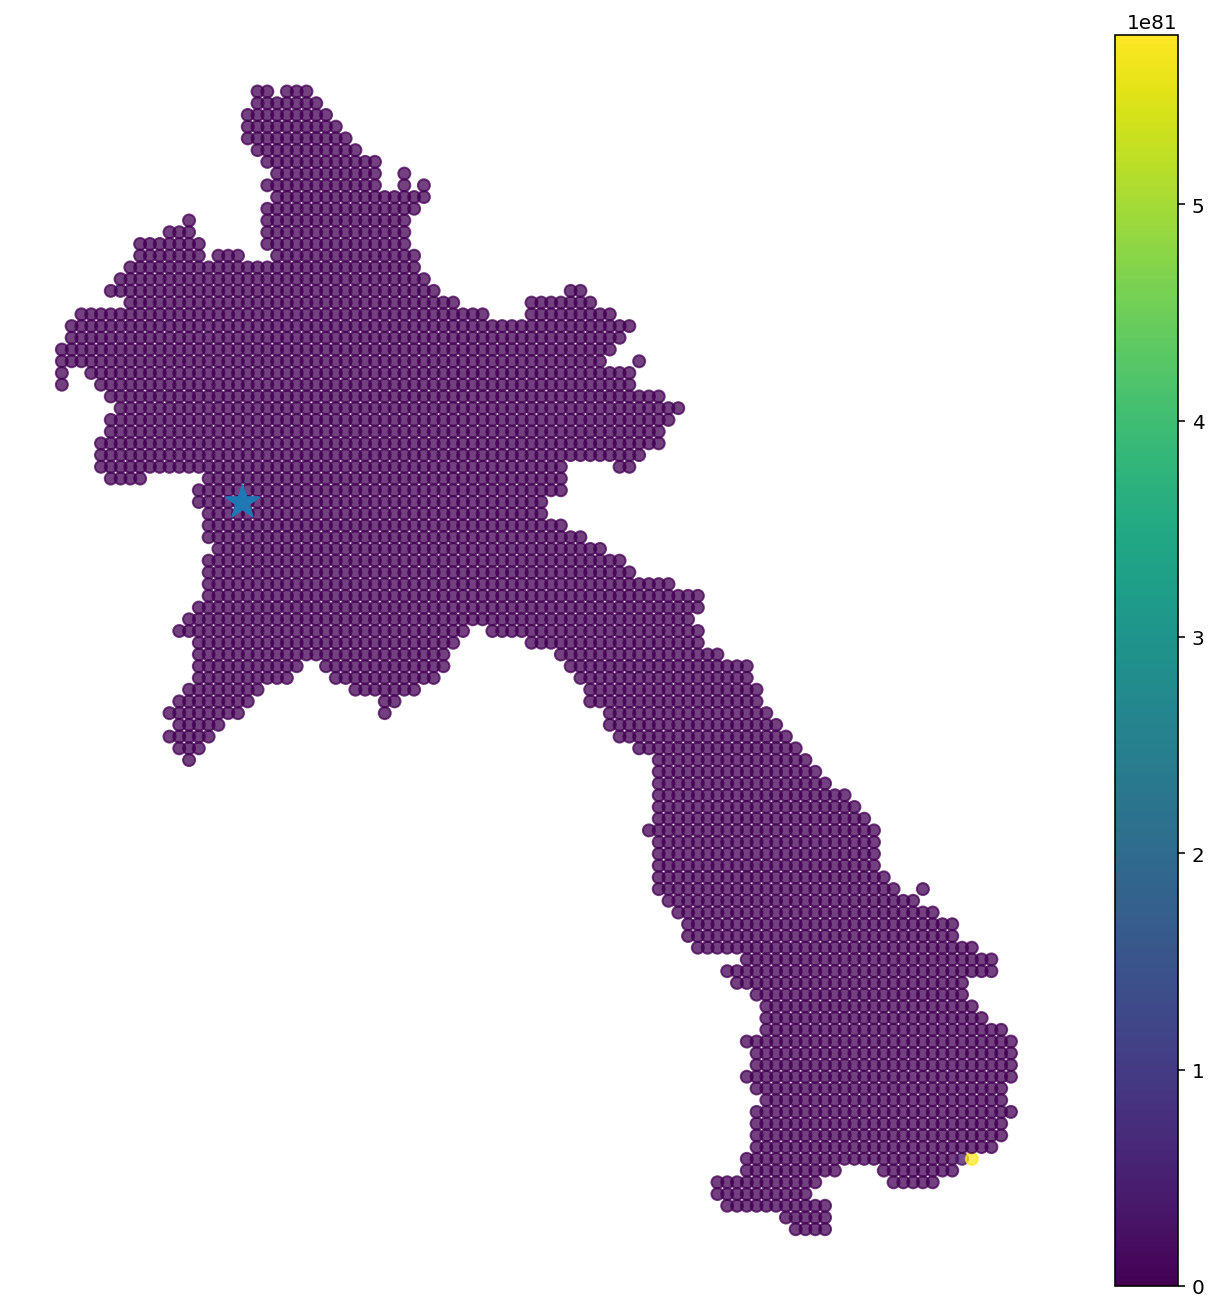

In [159]:
fig, ax = plt.subplots(figsize=(9, 9), dpi=144)
gpd.GeoDataFrame(laos_points.assign(damage_hat = idata_plot.posterior_predictive.laos_damage.mean(dim=['chain', 'draw']).values,
                   geometry = lambda x: gpd.points_from_xy(x=x.lon, y=x.lat))).plot('damage_hat', legend=True, alpha=0.75, ax=ax)
damage_df.query('ISO == "LAO"').plot.scatter(x='Longitude', y='Latitude', marker='*', s=300, ax=ax)
ax.axis('off')